In [168]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
import os
import sys
from copy import deepcopy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import scipy.spatial as sps
import scipy.stats as stats

from cdf import cdf

sys.path.append("../")

In [170]:
import project_utilities as utils
from sequence_analyzer import SequenceAnalyzer
# from sequence_analyzer_copy import SequenceAnalyzer

In [171]:
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["axes.grid"] = True
prefix = "non_gauss"

# Load Image

783 1415


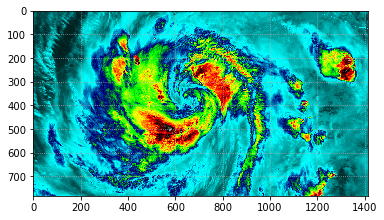

In [172]:
with PIL.Image.open("i05_060515_0811_hurrblanca_zoom.jpg") as im:
    Y = np.asarray(im)
    Y = utils.normalize(np.mean(Y, axis=-1) / 255)
    plt.imshow(im)
ny = Y.shape[0]
nx = Y.shape[1]
print(ny, nx)

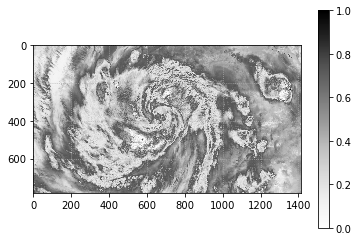

In [173]:
im = plt.imshow(Y, cmap="Greys")
plt.colorbar(im)

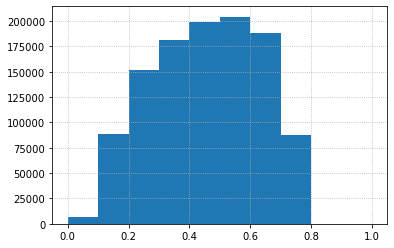

In [174]:
_ = plt.hist(Y.flatten())

# Sample Drillholes

In [175]:
np.random.seed(17)
ndh = 10
ncomps = ny
var = "var"
dhid = "dhid"
comps = pd.DataFrame(index=np.arange(ndh * ncomps), columns=[var])
comps[dhid] = np.repeat(np.arange(ndh), ncomps)
comps = comps[[dhid, var]]
# idxs = np.sort(np.random.randint(0, nx + 1, size=ndh))
idxs = np.linspace(nx / ndh, nx - (nx / ndh), ndh, dtype=int)
for i in range(ndh):
    comps.loc[comps[dhid] == i, var] = Y[:, idxs[i]]
comps = comps.astype({var: float})

'non_gauss_grid'

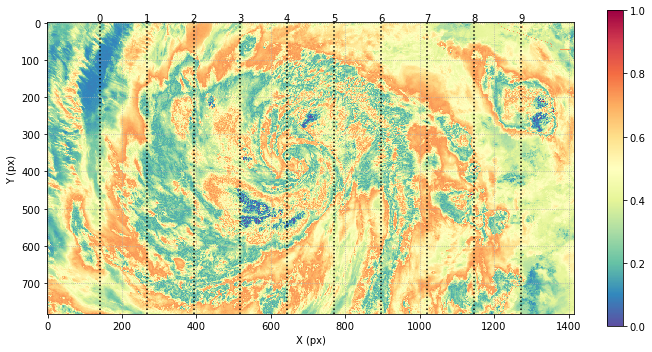

In [176]:
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(Y, cmap="Spectral_r")
plt.colorbar(im, ax=ax)
for i, idx in enumerate(idxs):
    ax.axvline(idx, ls=":", c="k")
    ax.text(idx, -5, f"{i}", ha="center")
ax.set_xlabel("X (px)")
ax.set_ylabel("Y (px)")
utils.savefig(f"{prefix}_grid", bbox_inches="tight")

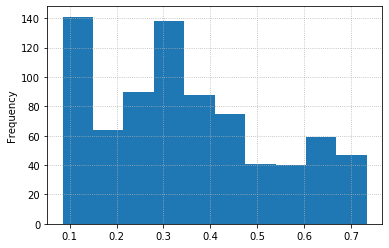

In [70]:
comps.loc[comps[dhid] == 0, var].plot(kind="hist")

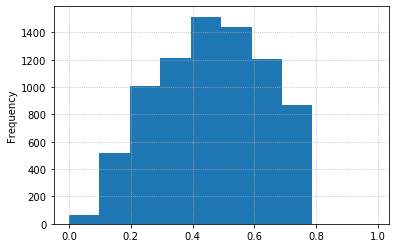

In [71]:
comps[var].plot(kind="hist")

In [72]:
np.save("dh_nongauss.npy", comps.loc[comps[dhid] == 3, var].values)

# Sequence Analyzer

In [73]:
sa = SequenceAnalyzer(
    comps,
    dhid,
    var,
    quantiles=np.arange(10, 100, 10),
    scale_factors=[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    nreals=100,
    seed=5841044,
    runs_above=True,
)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x200aab6df88>)

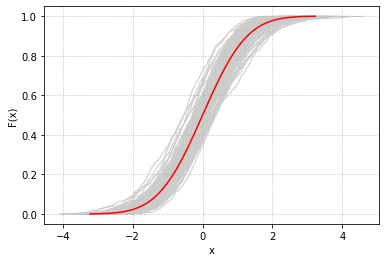

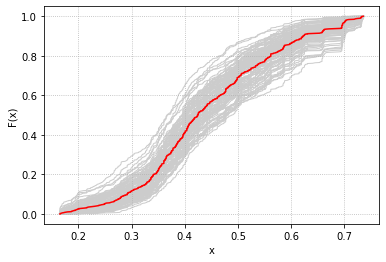

In [74]:
dh = 9
sa.check_reals(dh)
sa.check_reals(dh, gauss=False, log=False)

# Variogram Test

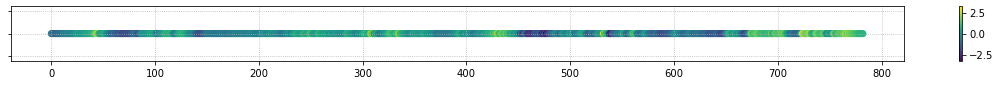

In [75]:
test_dhid = 3
test_dh = sa.dh_dict[test_dhid]["ns_data"]
expvario = sa.oned_variogram(test_dh)
nscorer = sa.dh_dict[test_dhid]["ns_transformer"]
_ = sa.plot_dh(dh=test_dhid)

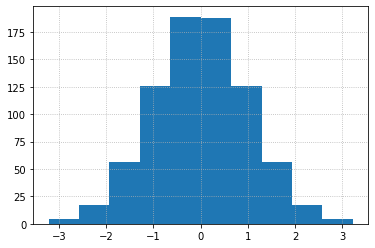

In [76]:
_ = plt.hist(test_dh)

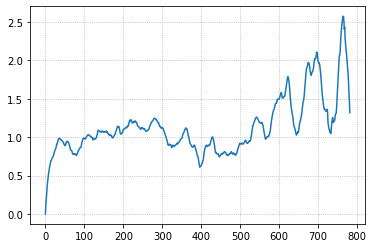

In [77]:
plt.plot(expvario)

In [78]:
def covar(t, d, r):
    """covariance calculation for standard models"""
    h = d / r
    if t == 1:  # Spherical
        c = 1 - h * (1.5 - 0.5 * h ** 2)
        c[h > 1] = 0
    elif t == 2:  # Exponential
        c = np.exp(-3 * h)
    elif t == 3:  # Gaussian
        c = np.exp(-3 * h ** 2)
    return c

In [79]:
def lusimspherical(d, r, nr, vtype, seed):
    """
    LU matrix simulation for an isotropic variogram
    d: distance matrix
    r: variogram range
    nr: number of realizations
    seed: random number seed
    """
    rng = np.random.default_rng(seed)
    c = covar(vtype, d, r)
    L = np.linalg.cholesky(c)

    # Draw normal random numbers
    if nr == 1:
        x = rng.normal(0, 1, d.shape[0])
    else:
        x = rng.normal(0, 1, [d.shape[0], nr])

    # Correlate with cholesky
    x = L @ x

    return [x, c]

In [80]:
import scipy.spatial as sps

vtype = [2, 2]
xranges = [20, 150]
c0 = 0.0
cc = [0.75, 0.25]
nst = len(vtype)
cova = np.zeros_like(test_dh)
P = np.arange(len(test_dh)) + 0.5
nx = test_dh.shape[0]

for i in range(nst):
    Q = P.copy()
    Q = Q / xranges[i]
    d = sps.distance_matrix(Q.reshape(-1, 1), Q.reshape(-1, 1))
    cova = cova + cc[i] * covar(vtype[i], d, r=1)
target_x = 1 - cova[0:nx, 0]
cx = cova[0:nx, 0]

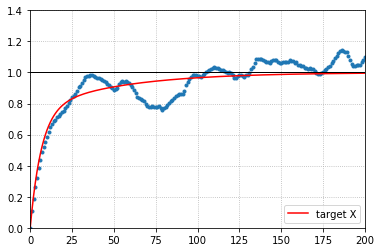

In [81]:
fig, ax = plt.subplots()
ax.plot(expvario, marker=".", ls="None")
ax.plot(target_x, label="target X", c="r")
ax.axhline(1.0, c="k", lw=1)
ax.set_xlim(0, 200)
ax.set_ylim(0, 1.4)
ax.legend(loc=4)

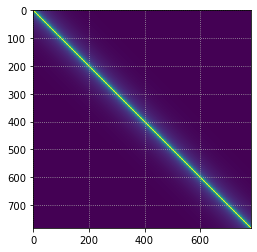

In [82]:
vmin = 0
vmax = 1
plt.imshow(cova, vmin=vmin, vmax=vmax)

In [83]:
# nreals = 100
# Y = np.zeros([len(test_dh), nreals])
# for ns in range(nst):
#     Q = P.copy()
#     Q = Q / xranges[ns]
#     d = sps.distance_matrix(Q.reshape(-1, 1), Q.reshape(-1, 1))
#     sim, cova = lusimspherical(
#         d, r=1, nr=nreals, vtype=vtype[ns], seed=5481044
#     )
#     Y += cc[ns] * sim

# Z = np.zeros_like(Y)
# for ireal in range(sa.nreals):
#     Z[:, ireal] = nscorer.inverse_transform(Y[:, ireal])

In [84]:
# print(Y[:, 0].mean(), Y[:, 0].std())
# _ = plt.hist(Y[:, 0])

In [85]:
# print(Z[:, 0].mean(), Z[:, 0].std())
# _ = plt.hist(Z[:, 0])

In [86]:
# Y_test = np.zeros((len(test_dh), nst))

# for ns in range(nst):
#     Q = P.copy()
#     Q = Q / xranges[ns]
#     d = sps.distance_matrix(Q.reshape(-1, 1), Q.reshape(-1, 1))
#     Y_test[:, ns], cova = lusimspherical(
#         d, r=1, nr=1, vtype=vtype[ns], seed=1044 + ns * 1000
#     )

# print(Y_test[:, 0].mean(), Y_test[:, 0].std())
# print(Y_test[:, 1].mean(), Y_test[:, 1].std())
# _ = plt.hist(Y_test[:, 0])

In [87]:
# Y = Y_test[:, 0] * cc[0] + Y_test[:, 1] * cc[1]
# print(Y.mean(), Y.std())
# _ = plt.hist(Y)

License 832fced2509c9dea checked out by rms_ben to 11c15716e7496a0f expires in 59 minutes. RMSP version 1.8.12 is out of date. There is a new version 1.8.13 featuring optimizations to meshes, as well as a number of other optimizations, improvements, and fixes! Visit https://portal.resourcemodelingsolutions.com to download the updated version. Note that after upgrading this message may not update immediately.
0.4888452391641375 0.1566226069519675


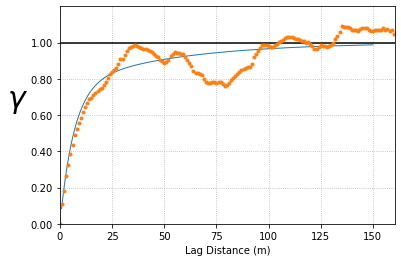

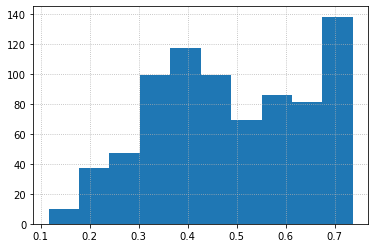

In [88]:
import rmsp

rmsp.activate()

griddef = rmsp.GridDef(
    0,
    0,
    0,
    nu=nx,
    nv=1,
    nz=1,
    usize=1,
    vsize=1,
    zsize=1,
    blockindices=np.arange(nx),
)
grid = rmsp.GridData(griddef=griddef)

vario_dict = dict(
    num_struct=2,
    nugget=0.0,
    shapes=["exponential"] * 2,
    var_contribs=[0.25, 0.75],
    angles=[[90.0, 0.0, 0.0], [90.0, 0.0, 0.0]],
    ranges=[[150, 1, 1], [20, 1, 1]],
)
vario = rmsp.VarioModel(vario_dict)

fig, ax = plt.subplots()
vario.plot(ax=ax)
ax.plot(expvario, marker=".", ls="None")

sim = rmsp.Simulator()
reals = sim.uncond_simulate(grid, vario, reals=100, seed=1044)

Z = np.zeros((nx, sa.nreals))
for i in range(sa.nreals):
    Z[:, i] = nscorer.inverse_transform(reals.get_real(i).values.ravel())

print(Z[:, 0].mean(), Z[:, 0].std())
fig, ax = plt.subplots()
_ = ax.hist(Z[:, 0])

# Continuous Variance

In [89]:
def colorgt(value):
    color = "red" if value >= 3.0 else "k"
    return f"color: {color}"

In [90]:
df = sa.nongauss_measure("scale_continuous")
utils.savetab(df, f"{prefix}_cont_var.tex")
df.style.applymap(colorgt)

,Scale Factor 1,Scale Factor 10,Scale Factor 20,Scale Factor 30,Scale Factor 40,Scale Factor 50,Scale Factor 60,Scale Factor 70,Scale Factor 80,Scale Factor 90,Scale Factor 100
dhid,,,,,,,,,,,
0,0.400628,0.548173,0.623127,0.668179,0.511517,0.501609,0.858903,0.802525,0.469690,0.388783,0.522330
1,0.002087,0.339211,0.244340,0.218246,0.211356,0.264782,0.111742,0.192522,0.043994,0.527697,0.505454
2,0.163700,0.616241,0.503560,0.763701,0.573790,0.334236,0.016500,0.269698,0.605617,0.599591,0.568336
3,0.025099,0.123446,0.076286,0.294015,0.037865,0.674699,0.005080,0.212692,0.202666,0.555709,0.145418
4,0.032073,0.512916,0.025766,0.104885,0.234383,0.824196,0.661962,0.699786,0.433378,0.687768,1.207593
5,0.039416,0.006417,0.007083,0.121399,0.100145,0.551037,0.063505,0.461834,0.628881,0.321096,0.987875
6,0.023947,0.372415,0.481622,0.354328,0.000974,0.251450,0.208417,0.084508,0.176868,1.248924,0.224863
7,0.041306,0.019836,0.005237,0.009103,0.169874,0.316104,0.399090,1.117415,0.136136,0.002818,0.425534
8,0.019081,0.450845,0.282716,0.614241,0.584765,0.811561,0.747261,1.256359,0.093480,0.178075,0.280982


In [91]:
# test traditional variogram model
# ds_reals = {f: sa._downsample_realizations(Y, f) for f in sa.scale_factors}
ds_reals = {f: sa._downsample_realizations(Z, f) for f in sa.scale_factors}

cont_var = {f: [] for f in sa.scale_factors}
cont_mean = {f: [] for f in sa.scale_factors}

for f in sa.scale_factors:
    for ireal in range(sa.nreals):
        cont_var[f].append(np.var(ds_reals[f][:, ireal]))
        cont_mean[f].append(np.mean(ds_reals[f][:, ireal]))

df = pd.DataFrame(columns=[f"Scale Factor {f}" for f in sa.scale_factors])
df.index.name = sa.dhid
for f in sa.scale_factors:
    x = sa.dh_dict[test_dhid]["cont_var"][f]
    df.loc[test_dhid, f"Scale Factor {f}"] = np.abs(
        sa.standardize(x, cont_var[f])
    )
df.style.applymap(colorgt)

,Scale Factor 1,Scale Factor 10,Scale Factor 20,Scale Factor 30,Scale Factor 40,Scale Factor 50,Scale Factor 60,Scale Factor 70,Scale Factor 80,Scale Factor 90,Scale Factor 100
dhid,,,,,,,,,,,
3,0.488231,0.891639,1.017778,1.483083,0.839095,1.878518,0.618589,0.763467,0.771930,1.434889,0.315074


'non_gauss_reals'

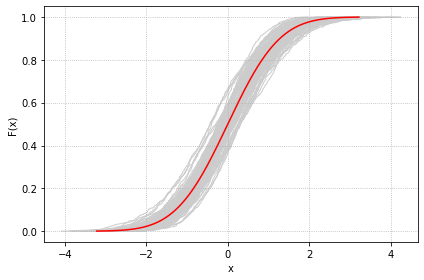

In [164]:
dh = 2
sa.check_reals(dh)
utils.savefig(f"{prefix}_reals")

'non_gauss_reals_bt'

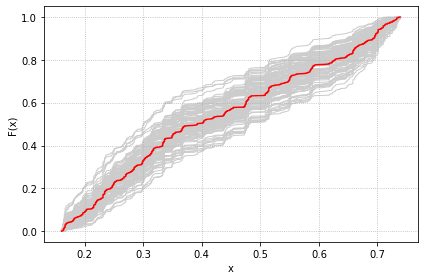

In [165]:
sa.check_reals(dh, gauss=False, log=False)
utils.savefig(f"{prefix}_reals_BT")

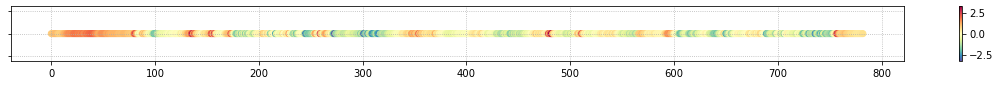

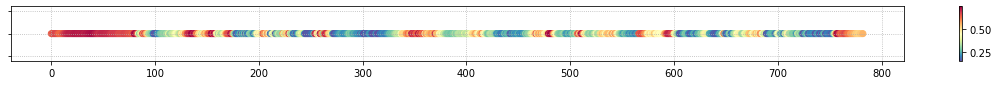

In [166]:
_ = sa.plot_dh(dh, cmap="Spectral_r")
_ = sa.plot_dh(dh, gauss=False, cmap="Spectral_r")

'non_gauss_cont_var'

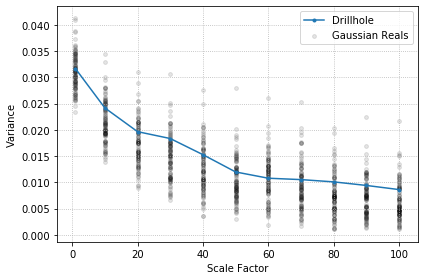

In [167]:
_ = sa.diagnostic_plot("scale_continuous", dh)
utils.savefig(f"{prefix}_cont_var")

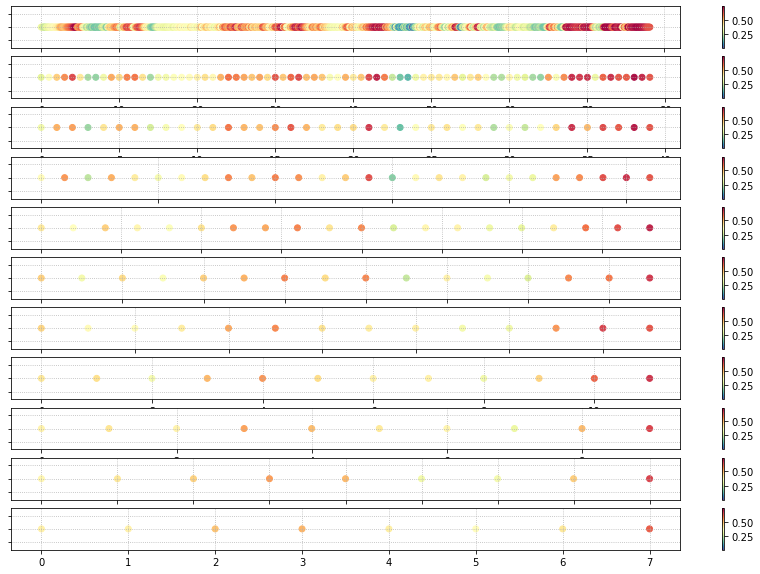

In [96]:
vmin = sa.dh_dict[dh]["x_numpy"].min()
vmax = sa.dh_dict[dh]["x_numpy"].max()

_ = sa.plot_downscaled_dh(dh, cmap="Spectral_r", vmin=vmin, vmax=vmax)

# Total Runs

In [97]:
df = sa.nongauss_measure("total_runs")
utils.savetab(df, f"{prefix}_total_runs.tex")
df.style.applymap(colorgt)

,0.1 Indicator,0.2 Indicator,0.3 Indicator,0.4 Indicator,0.5 Indicator,0.6 Indicator,0.7 Indicator,0.8 Indicator,0.9 Indicator
dhid,,,,,,,,,
0,1.326626,0.629049,0.643034,0.530115,0.017211,0.145222,0.137005,0.349170,0.254119
1,0.279134,1.615012,2.006170,0.818957,0.752746,0.011217,0.139132,0.281610,0.324820
2,0.466142,1.068627,1.180974,1.645106,1.962462,3.157725,4.160497,4.164712,1.272091
3,1.783400,5.010761,0.618741,0.525945,0.476582,0.171828,0.365410,0.619176,0.002443
4,0.249354,2.433644,4.318549,4.679383,6.453032,4.101485,2.105232,0.369268,0.431686
5,0.210915,2.945921,2.154426,2.844560,1.960143,1.916750,1.183414,0.276890,0.371113
6,0.743989,3.690539,7.412787,4.239359,1.698253,1.507804,1.333528,0.935481,0.063724
7,1.106478,0.806123,0.069160,0.759460,2.312479,3.974424,4.635125,2.038551,0.385306
8,2.083695,4.077974,3.369355,4.390491,6.145552,2.603284,4.022208,2.022812,0.631287


In [100]:
# test traditional variogram model
ind_reals = sa._realization_indicator_transform(Z)
# ind_reals = sa._realization_indicator_transform(Z, sa.dh_dict[test_dhid]["thresholds"])

runs_reals = {
    q / 100: sa._binary_runs_realizations(ind_reals[q / 100])
    for q in sa.quantiles
}

df = pd.DataFrame(columns=[f"{q} Indicator" for q in sa.thresholds.keys()])
df.index.name = sa.dhid
for q, t in sa.thresholds.items():
    tot_runs = []
    for ireal in range(sa.nreals):
        tot_runs.append(len(runs_reals[q]["cum_runs"][ireal]))
    x = len(sa.dh_dict[test_dhid]["runs"][q]["cum_runs"])
    df.loc[test_dhid, f"{q} Indicator"] = np.abs(sa.standardize(x, tot_runs))
df.style.applymap(colorgt)

,0.1 Indicator,0.2 Indicator,0.3 Indicator,0.4 Indicator,0.5 Indicator,0.6 Indicator,0.7 Indicator,0.8 Indicator,0.9 Indicator
dhid,,,,,,,,,
3,1.911347,4.040971,0.834090,0.650094,0.575657,0.351834,0.573251,0.886090,0.319254


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2008f7e3448>)

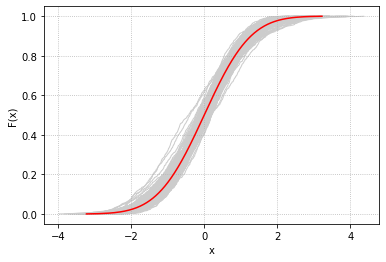

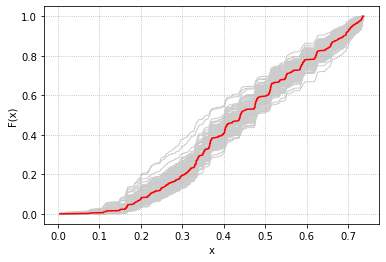

In [195]:
dh = 3
sa.check_reals(dh)
sa.check_reals(dh, gauss=False, log=False)

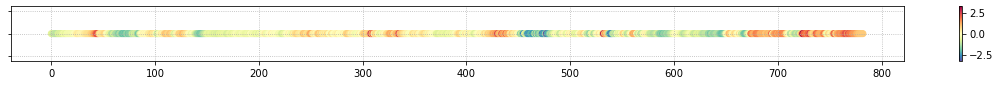

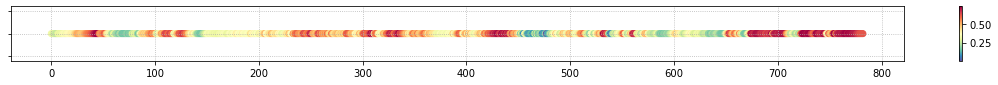

In [196]:
_ = sa.plot_dh(dh, cmap="Spectral_r")
_ = sa.plot_dh(dh, gauss=False, cmap="Spectral_r")

'non_gauss_total_runs'

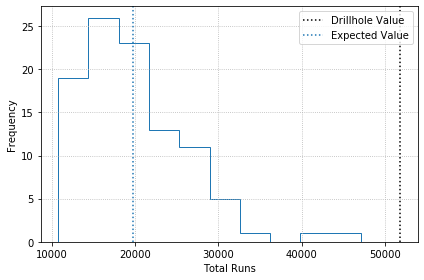

In [197]:
q = 0.2
_ = sa.diagnostic_plot("total_runs", dh, q)
utils.savefig(f"{prefix}_total_runs")

'non_gauss_indicators'

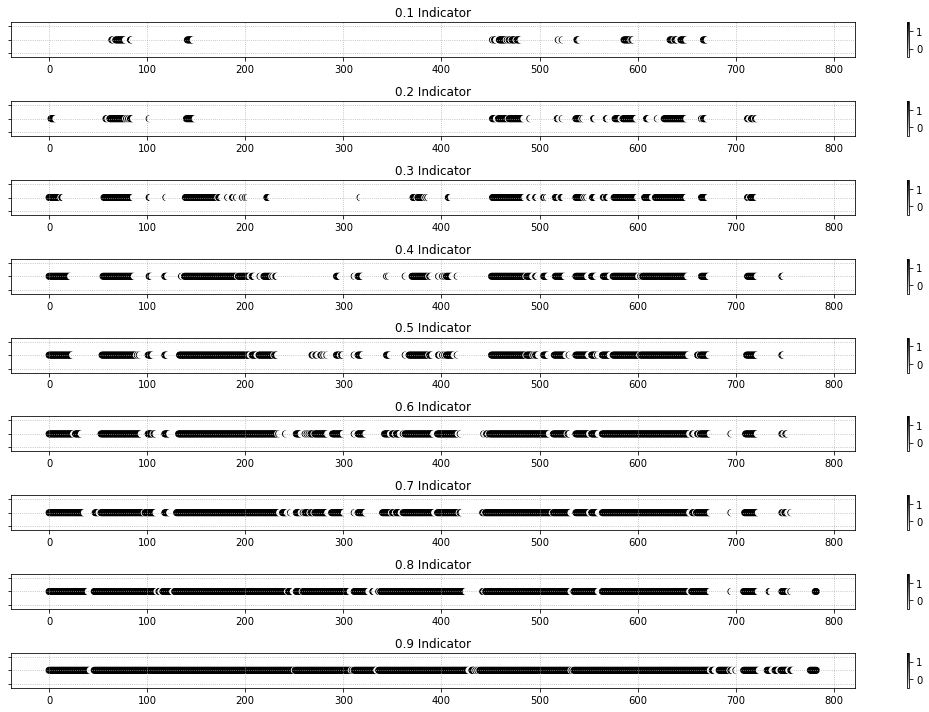

In [198]:
fig, ax = sa.plot_indicators(dh, cmap="binary", figsize=(15, 10))
fig.tight_layout()
utils.savefig(f"{prefix}_indicators")

# Cumulative Runs

In [207]:
df = sa.nongauss_measure("run_length_freqs", max_runs=30)
utils.savetab(df, f"{prefix}_run_length_freqs.tex")
df.style.applymap(colorgt)

,0.1 Indicator,0.2 Indicator,0.3 Indicator,0.4 Indicator,0.5 Indicator,0.6 Indicator,0.7 Indicator,0.8 Indicator,0.9 Indicator
dhid,,,,,,,,,
0,0.617935,0.471188,0.397512,0.484581,0.495096,0.285940,0.178850,0.273056,0.230131
1,0.739306,1.618158,1.948444,1.560959,1.444419,0.423447,0.389209,0.322549,0.252293
2,0.341691,1.375271,1.251225,1.368702,1.349150,2.097630,2.982319,3.394473,1.669736
3,0.898525,1.353636,1.039322,0.792240,0.767294,0.521028,0.629014,0.676721,0.094264
4,0.305140,1.919851,2.951185,3.365602,3.785778,3.082928,2.012301,0.502840,0.389034
5,0.113337,1.186354,1.564055,2.052736,1.753359,1.745449,1.263753,0.243790,0.322253
6,0.264361,1.907361,2.749428,2.735313,1.727584,1.521523,1.466622,0.862917,0.264101
7,0.139919,0.330415,0.105641,0.372489,1.121440,1.794425,2.127717,1.856425,0.385899
8,0.778495,2.130911,1.714376,2.873916,3.452188,2.165865,2.723110,1.957115,0.649151


In [148]:
df.max()

0.1 Indicator    0.898525
0.2 Indicator    2.130911
0.3 Indicator    2.951185
0.4 Indicator    3.365602
0.5 Indicator    3.785778
0.6 Indicator    3.082928
0.7 Indicator    2.982319
0.8 Indicator    3.394473
0.9 Indicator    1.669736
dtype: float64

In [181]:
# test traditional variogram
max_runs = 30
df = pd.DataFrame(columns=[f"{q} Indicator" for q in sa.thresholds.keys()])
df.index.name = sa.dhid

for q, t in sa.thresholds.items():
    dh_runs = sa.dh_dict[test_dhid]["runs"][q]["cum_runs_freqs"]
    nruns = min(len(dh_runs), max_runs)
    temp = np.zeros((sa.nreals, len(sa.dh_dict[test_dhid]["x_numpy"])))
    for ireal in range(sa.nreals):
        real_run_freqs = runs_reals[q]["cum_runs_freqs"][ireal]
        idxs = np.arange(len(real_run_freqs))
        temp[ireal, idxs] = real_run_freqs
    x = dh_runs[:nruns]
    d = temp[:, :nruns]
    scores = [sa.standardize(x[i], d[:, i]) for i in range(nruns)]
    score = np.mean(np.abs(scores))
    df.loc[test_dhid, f"{q} Indicator"] = score
df.style.applymap(colorgt)

,0.1 Indicator,0.2 Indicator,0.3 Indicator,0.4 Indicator,0.5 Indicator,0.6 Indicator,0.7 Indicator,0.8 Indicator,0.9 Indicator
dhid,,,,,,,,,
3,0.756795,1.069210,1.028098,0.893506,0.876277,0.528671,0.664832,0.893971,0.402016


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x20095b107c8>)

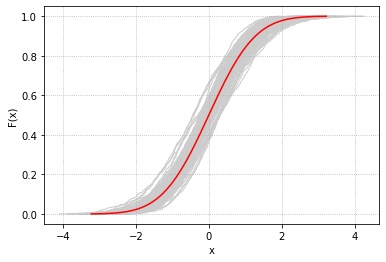

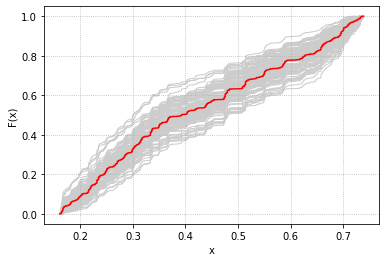

In [209]:
dh = 2
sa.check_reals(dh)
sa.check_reals(dh, gauss=False, log=False)

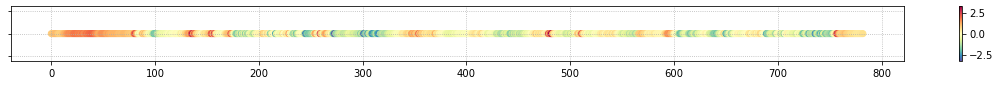

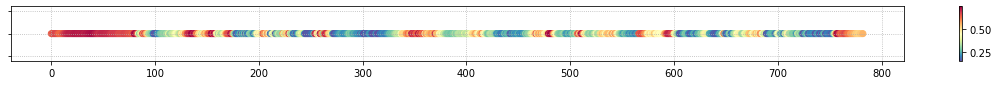

In [210]:
_ = sa.plot_dh(dh, cmap="Spectral_r")
_ = sa.plot_dh(dh, gauss=False, cmap="Spectral_r")

'non_gauss_run_length_freqs'

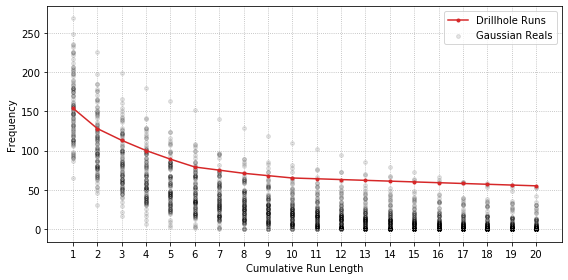

In [211]:
q = 0.8
f = None
max_runs = 20
figsize = (8, 4)
_ = sa.diagnostic_plot(
    "run_length_freqs", dh, q, max_runs=max_runs, figsize=figsize
)
utils.savefig(f"{prefix}_run_length_freqs")

# h-Scatter

0.8170702978434455


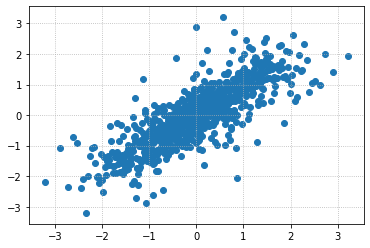

In [201]:
# h-scatter
x = sa.dh_dict[dh]["ns_data"]
array = np.asarray(x)
nx = array.shape[0]
cx = np.zeros(nx - 1)
h = 3
for i in range(1, h):
    z0 = array[0 : nx - i]
    z1 = array[i:nx]
    dz = (z1 * z0) - np.mean(z0) * np.mean(z1)
    cx[i] = np.sum(dz) / (nx - i)
plt.scatter(z0, z1)
print(np.cov(z0, z1)[0, 1])

0.07682458386683738
0.08194622279129321


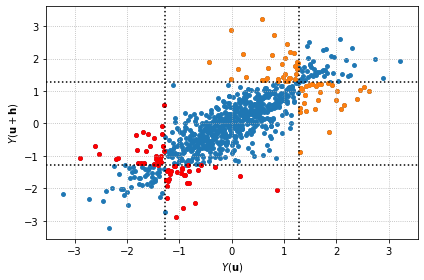

In [203]:
thresh = 1.28
mask1 = ((z0 < -thresh) & (z1 >= -thresh)) | ((z0 >= -thresh) & (z1 < -thresh))
mask2 = ((z0 < thresh) & (z1 >= thresh)) | ((z0 >= thresh) & (z1 < thresh))
fig, ax = plt.subplots()
ax.scatter(z0, z1, s=15)
ax.scatter(z0[mask1], z1[mask1], c="r", s=15)
ax.scatter(z0[mask2], z1[mask2], c="C1", s=15)
ax.axvline(thresh, c="k", ls=":")
ax.axhline(thresh, c="k", ls=":")
ax.axvline(-thresh, c="k", ls=":")
ax.axhline(-thresh, c="k", ls=":")
ax.set_xlabel("$Y(\mathbf{u})$")
ax.set_ylabel("$Y(\mathbf{u}+\mathbf{h})$")
utils.savefig("hscatter")

print(len(z0[mask1]) / len(z0))
print(len(z0[mask2]) / len(z0))

# n-Point Connectivity

In [116]:
nstep = 20
df = sa.nongauss_measure("n_pt_connectivity", nstep=nstep)
utils.savetab(df, f"{prefix}_n_pt_connectivity.tex")
df.style.applymap(colorgt)

,0.1 Indicator,0.2 Indicator,0.3 Indicator,0.4 Indicator,0.5 Indicator,0.6 Indicator,0.7 Indicator,0.8 Indicator,0.9 Indicator
dhid,,,,,,,,,
0,0.262774,0.350274,0.273261,0.315413,0.409900,0.447172,0.373590,0.197127,0.397674
1,0.474658,0.791404,1.295002,1.295656,1.494392,1.257486,1.113968,0.483153,0.439773
2,0.705269,0.578351,1.180569,1.246108,1.114658,1.010928,0.772942,1.000103,0.118951
3,0.389848,0.253402,1.034943,1.073178,0.874610,1.121361,0.807457,1.411892,0.419131
4,0.299406,0.397305,0.640003,0.928344,1.194777,1.525746,2.392090,1.476522,0.569483
5,0.150669,0.403947,0.629530,0.977944,1.117739,1.347225,0.587392,0.459254,0.162667
6,0.589214,0.214354,0.587035,1.045584,1.374730,1.128825,0.509396,1.196620,0.291805
7,0.182262,0.291014,0.489125,0.184440,0.205654,0.648430,1.263801,1.456826,0.749450
8,0.397279,3.933022,3.847338,2.748842,1.962521,2.046186,2.256464,1.815748,1.061974


'non_gauss_n_pt_connectivity'

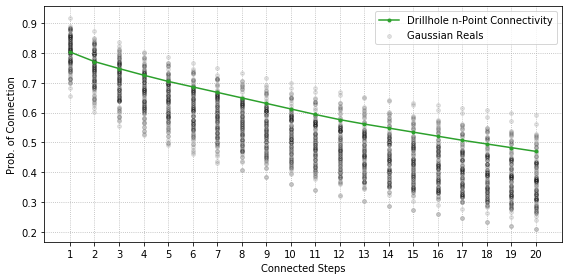

In [212]:
dh = 2
q = 0.8
f = None
max_runs = None

figsize = (8, 4)
fig, ax = sa.diagnostic_plot(
    "n_pt_connectivity", dh, q, f, max_runs, nstep, figsize
)
# ax.set_ylim(top=1.0)
utils.savefig(f"{prefix}_n_pt_connectivity")

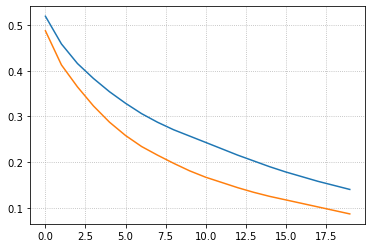

In [122]:
def n_pt_conn(x, nstep):
    """n-point connectivity fucntion of binary array x"""
    x = np.asarray(x)
    nx = x.shape[0]
    phi_n = []
    for n in range(1, nstep + 1):
        prod = []
        for i in range(nx - n + 1):
            idxs = [i] + [j + i for j in range(n)]
            a = [x[idx] for idx in idxs]
            prod.append(np.prod(a))
        phi_n.append(np.mean(prod))
    return phi_n


dh = 5
ireal = 8
q = 0.5
ind = sa.dh_dict[dh]["indicators"][f"{q} Indicator"].values
plt.plot(n_pt_conn(ind, nstep))
plt.plot(n_pt_conn(sa.dh_dict[dh]["ind_reals"][q][:, ireal], nstep))